In [21]:
import sqlalchemy as sa
import pandas as pd
import numpy as np 
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

import statsmodels.api as sm
from scipy.spatial import distance_matrix
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import ttest_1samp
from sklearn.cross_decomposition import CCA
from sklearn.preprocessing import StandardScaler
import faiss

### FUNCTIONS

In [2]:
def read_clickhouse(q):

    ch_host = "10.65.23.82"
    ch_cert = "/home/jovyan/CA.pem"
    ch_port = "9440"
    ch_db = "analytics"
    ch_user = ""
    ch_pass = ""

    connection_string = "clickhouse+native://{}:{}@{}:{}/{}?secure=True".format(
        ch_user, ch_pass, ch_host, ch_port, ch_db
    )

    engine = sa.create_engine(connection_string)
    return pd.read_sql_query(q, con=engine)

In [171]:
def q_app_visits(start_date, end_date):
    q = f"""
    select 
        anonymous_id,
        count(event) as event_activity 
        
    from event.new_app
    where 1=1
        and toDate(ts) between toDate('{start_date}') and toDate('{end_date}')
        and dwh_dt between toDate('{start_date}') and toDate('{end_date}')
        and event in (
        'Product Added',
        'Login',
        'Shop Selected',
        'Address Change Initiated',
        'Product Viewed',
        'Search Results Viewed',
        'Category Viewed',
        'Shop Selection Started',
        'Pickup Map Opened',
        'Retailer Selection Started',
        'Checkout Sber Spasibo Form Opened',
        'Map Pickup Shop Selected',
        'Checkout Button Clicked', 
        'Checkout Loaded', 
        'Main Page Viewed', 
        'Checkout Slot Selection Started',
        'Checkout Delivery Slot Selection Started',
        'Checkout Delivery Slot Selected', 
        'Cart Viewed', 
        'Search Started', 
        'Banner Viewed', 
        'Recommendation Block View', 
        'Product Category Viewed', 
        'Catalogue Tab Clicked',
        'Add To Cart Clicked', 
        'Onboarding Banner Viewed', 
        'Order Info Viewed', 
        'Product Sort Initiated',
        'Product Filter Initiated',
        'Product Sorted', 
        'Cart Params Loaded',
        'Address Selected', 
        'Address Search Opened',
        'Address Suggest Clicked',
        'Redirected From SBOL',
        'Sberid Authorization Prompt Shown',
        'Map Pickup Button Clicked',
        'Age Confirmation Viewed',
        'Alcohol Pickup Popup_completed',
        'Favorites Tab Clicked',
        'Address Change Clicked',
        'Retailer Selected')

    group by anonymous_id
    """
    return q

In [172]:
def q_user_info(start_date, end_date):
    q = f"""
select 
        distinct anonymous_id,
        timezone, 
        platform, 
        app_version
        
    from event.new_app
    where 1=1
        and toDate(ts) between toDate('{start_date}') and toDate('{end_date}')
        and dwh_dt between toDate('{start_date}') and toDate('{end_date}')
        and event in (
        'Product Added',
        'Login',
        'Shop Selected',
        'Address Change Initiated',
        'Product Viewed',
        'Search Results Viewed',
        'Category Viewed',
        'Shop Selection Started',
        'Pickup Map Opened',
        'Retailer Selection Started',
        'Checkout Sber Spasibo Form Opened',
        'Map Pickup Shop Selected',
        'Checkout Button Clicked', 
        'Checkout Loaded', 
        'Main Page Viewed', 
        'Checkout Slot Selection Started',
        'Checkout Delivery Slot Selection Started',
        'Checkout Delivery Slot Selected', 
        'Cart Viewed', 
        'Search Started', 
        'Banner Viewed', 
        'Recommendation Block View', 
        'Product Category Viewed', 
        'Catalogue Tab Clicked',
        'Add To Cart Clicked', 
        'Onboarding Banner Viewed', 
        'Order Info Viewed', 
        'Product Sort Initiated',
        'Product Filter Initiated',
        'Product Sorted', 
        'Cart Params Loaded',
        'Address Selected', 
        'Address Search Opened',
        'Address Suggest Clicked',
        'Redirected From SBOL',
        'Sberid Authorization Prompt Shown',
        'Map Pickup Button Clicked',
        'Age Confirmation Viewed',
        'Alcohol Pickup Popup_completed',
        'Favorites Tab Clicked',
        'Address Change Clicked',
        'Retailer Selected')
    """
    return q

In [173]:
def q_app(start_date, end_date):
    q = f"""
with 
    toDate('{start_date}') as start_date,
    toDate('{end_date}') as end_date,
    
visits as (
    
    select 
        anonymous_id,
        order_id,
        toDate(ts) as dt,
        0 as order_completed_flg
    from event.new_app
    where 1=1
        and toDate(ts) between start_date and end_date
        and dwh_dt between start_date and end_date
        and event in (
        'Product Added',
        'Login',
        'Shop Selected',
        'Address Change Initiated',
        'Product Viewed',
        'Search Results Viewed',
        'Category Viewed',
        'Shop Selection Started',
        'Pickup Map Opened',
        'Retailer Selection Started',
        'Checkout Sber Spasibo Form Opened',
        'Map Pickup Shop Selected',
        'Checkout Button Clicked', 
        'Checkout Loaded', 
        'Main Page Viewed', 
        'Checkout Slot Selection Started',
        'Checkout Delivery Slot Selection Started',
        'Checkout Delivery Slot Selected', 
        'Cart Viewed', 
        'Search Started', 
        'Banner Viewed', 
        'Recommendation Block View', 
        'Product Category Viewed', 
        'Catalogue Tab Clicked',
        'Add To Cart Clicked', 
        'Onboarding Banner Viewed', 
        'Order Info Viewed', 
        'Product Sort Initiated',
        'Product Filter Initiated',
        'Product Sorted', 
        'Cart Params Loaded',
        'Address Selected', 
        'Address Search Opened',
        'Address Suggest Clicked',
        'Redirected From SBOL',
        'Sberid Authorization Prompt Shown',
        'Map Pickup Button Clicked',
        'Age Confirmation Viewed',
        'Alcohol Pickup Popup_completed',
        'Favorites Tab Clicked',
        'Address Change Clicked',
        'Retailer Selected')

    group by anonymous_id, order_id, dt
    
    union all
    
    select 
        anonymous_id,
        params['order_number'] as order_id,
        toDate(ts) as dt,
        1 as order_completed_flg
    from event.new_app
    where 1=1
        and event = 'Order Completed'
        and toDate(ts) between start_date and end_date
        and dwh_dt between start_date and end_date
    group by anonymous_id, order_id, dt
),
financial_measures as (
        select 
            uuid,
            order_number,
            sumIf(1, type_delivery=='asap') as express_flg,
            sumIf(1, type_delivery=='planned') as planned_flg,
            sumIf(1, type_delivery=='pickup') as pickup_flg,
            sumIf(gmv_advertising, type_delivery = 'asap') + sumIf(gmv_service_fee_net_promo, type_delivery = 'asap') + sumIf(gmv_goods_net_promo, type_delivery = 'asap') as gmv_net_of_promo_express,
            sumIf(gmv_advertising, type_delivery = 'planned') + sumIf(gmv_service_fee_net_promo, type_delivery = 'planned') + sumIf(gmv_goods_net_promo, type_delivery = 'planned') as gmv_net_of_promo_planned,
            sumIf(gmv_advertising, type_delivery = 'pickup') + sumIf(gmv_service_fee_net_promo, type_delivery = 'pickup') + sumIf(gmv_goods_net_promo, type_delivery = 'pickup') as gmv_net_of_promo_pickup,
            sum(gmv_advertising) + sum(gmv_service_fee_net_promo) + sum(gmv_goods_net_promo) as gmv_net_of_promo,
            sumIf(gross_profit, type_delivery = 'asap') as gross_profit_express,
            sumIf(gross_profit, type_delivery = 'planned') as gross_profit_planned,
            sumIf(gross_profit, type_delivery = 'pickup') as gross_profit_pickup,
            sum(gross_profit) as gross_profit_full

        from analytics.financial_measures
        where 1=1
            and toDate(completed_at) between start_date and end_date
            and user_id is not null
            and order_state = 'complete'
            and order_id not in (
                select distinct 
                    order_id
                from analytics.shipments
                where toDate(completed_at) between start_date and end_date
                    and b2b_order_company_flg = 1
            )
            and order_number not in 
            (
                select order_number
                from analytics.shipments
                where 1=1
                    and toDate(completed_at) between start_date and end_date
                    and owner_type = 'ServiceAccount'
            )
        group by dictGet('analytics.spree_users_dict', 'uuid', toUInt64(user_id)) as uuid, order_number
    )

    select 
        anonymous_id, 
        uniqExactIf(order_id, uuid != '') as orders,
        sum(gmv_net_of_promo) as gmv_per_user 

    from visits
    left join financial_measures
        on order_id = order_number
        group by anonymous_id
    """

    return q

### METHODS

In [174]:
def wo_reduction(exp):
    data = exp.copy()
    data["const"] = 1
    model = sm.OLS(data['y'], data[['const', 'group']]).fit()
    effect = model.params['group']
    pvalue = model.pvalues['group']
    ci_len = model.conf_int(alpha=0.05)[1]['group'] - model.conf_int(alpha=0.05)[0]['group']
    return effect, pvalue, ci_len 

In [451]:
def cuped_control_only_1_cov(exp):
    tmp = exp.copy()
    X_cov = tmp.drop(["y","group"],axis=1)[["gmv_per_user_past"]]
    y_control = tmp.query("group==0")['y']
    X_cov_control = tmp.query("group==0")[["gmv_per_user_past"]]
    y_hat = sm.OLS(y_control, X_cov_control).fit().predict(X_cov)
    tmp['y_cuped'] = tmp['y'].values-y_hat
    y_cup = tmp['y_cuped']
    X_cup = tmp["group"]
    X_cup = sm.add_constant(X_cup)
    model2 = sm.OLS(y_cup, X_cup).fit()
    effect = model2.params['group']    
    pvalue = model2.pvalues['group']
    ci_len = model2.conf_int(alpha=0.05)[1]['group'] - model2.conf_int(alpha=0.05)[0]['group']
    return effect, pvalue, ci_len 

In [175]:
def cuped_control_only(exp):
    tmp = exp.copy()
    X_cov = tmp.drop(["y","group"],axis=1)
    y_control = tmp.query("group==0")['y']
    X_cov_control = tmp.query("group==0").drop(["y","group"],axis=1)
    y_hat = sm.OLS(y_control, X_cov_control).fit().predict(X_cov)
    tmp['y_cuped'] = tmp['y'].values-y_hat
    y_cup = tmp['y_cuped']
    X_cup = tmp["group"]
    X_cup = sm.add_constant(X_cup)
    model2 = sm.OLS(y_cup, X_cup).fit()
    effect = model2.params['group']    
    pvalue = model2.pvalues['group']
    ci_len = model2.conf_int(alpha=0.05)[1]['group'] - model2.conf_int(alpha=0.05)[0]['group']
    return effect, pvalue, ci_len 

In [176]:
def cupac(exp): 
    tmp = exp.copy()
    X_cov = tmp.drop(["y", "group"],axis=1)
    y_hat = rf.predict(X_cov)
    tmp['y_cuped'] = tmp['y'].values-y_hat
    y_cup = tmp['y_cuped']
    X_cup = tmp["group"]
    X_cup = sm.add_constant(X_cup)
    model2 = sm.OLS(y_cup, X_cup).fit()
    effect = model2.params['group']    
    pvalue = model2.pvalues['group']
    ci_len = model2.conf_int(alpha=0.05)[1]['group'] - model2.conf_int(alpha=0.05)[0]['group']
    return effect, pvalue, ci_len

In [385]:
def matched_control_random_missing(exp,
                                   cov_control_no_missing,
                                   cov_test_no_missing,
                                   test_no_missing,
                                   control_no_missing, 
                                   y_missing_control,
                                   y_missing_test):
    exp_tmp = exp.copy()
    
    topn = 1
    dim = cov_control_no_missing.shape[1]
    k = 4096
    min_point_per_cluster = 5
    nprobe = 512
    quantiser = faiss.IndexFlatL2(dim)
    index = faiss.IndexIVFFlat(quantiser, dim, k)
    index.cp.min_points_per_centroid = min_point_per_cluster
    
    index.train(cov_control_no_missing)
    index.add(cov_control_no_missing)
    D, I = index.search(cov_test_no_missing, 1)
    I = I.reshape(I.shape[0])
    test_no_missing["y_control"] = control_no_missing.iloc[I]["y"].to_numpy()
    not_missing_deltas = (test_no_missing["y"] - test_no_missing["y_control"]).to_numpy()
    matched_missing_y = np.random.choice(y_missing_control, 
                                         size=y_missing_test.shape[0])
    missing_deltas = y_missing_test - matched_missing_y
    all_deltas = np.concatenate([missing_deltas, not_missing_deltas])
    pvalue = ttest_1samp(all_deltas, 0).pvalue
    effect = all_deltas.mean()
    
    return effect, pvalue

In [414]:
def matched_control_cat_missing(exp,
                                cov_control_no_missing,
                                cov_test_no_missing,
                                control_no_missing,
                                test_no_missing,
                                cov_control_missing,
                                cov_test_missing,
                                control_missing,
                                test_missing):
    exp_tmp = exp.copy()
    
    topn = 1
    dim = cov_control_no_missing.shape[1]
    k = 4096
    min_point_per_cluster = 5
    nprobe = 512
    quantiser = faiss.IndexFlatL2(dim)
    index = faiss.IndexIVFFlat(quantiser, dim, k)
    index.cp.min_points_per_centroid = min_point_per_cluster
    
    index.train(cov_control_no_missing)
    index.add(cov_control_no_missing)
    D, I = index.search(cov_test_no_missing, 1)
    I = I.reshape(I.shape[0])
    test_no_missing["y_control"] = control_no_missing.iloc[I]["y"].to_numpy()
    not_missing_deltas = (test_no_missing["y"] - test_no_missing["y_control"]).to_numpy()
    
    dim = cov_control_missing.shape[1]
    quantiser = faiss.IndexFlatL2(dim)
    index = faiss.IndexIVFFlat(quantiser, dim, k)
    index.cp.min_points_per_centroid = min_point_per_cluster
    
    index.train(cov_control_missing)
    index.add(cov_control_missing)
    D, I = index.search(cov_test_missing, 1)
    I = I.reshape(I.shape[0])
    test_missing["y_control_missing"] = control_missing.iloc[I]["y"].to_numpy()
    missing_deltas = (test_missing["y"] - test_missing["y_control_missing"]).to_numpy()
    
    all_deltas = np.concatenate([missing_deltas, not_missing_deltas])
    pvalue = ttest_1samp(all_deltas, 0).pvalue
    effect = all_deltas.mean()
    
    return effect, pvalue

In [424]:
def matched_on_rf(exp):
    exp_tmp = exp.copy()
    exp_tmp["y_hat"] = rf.predict(exp_tmp.drop(["y", "group"], axis=1))

    cov_control = np.float32(exp_tmp[exp_tmp.group==0][["y_hat"]].to_numpy())
    cov_test = np.float32(exp_tmp[exp_tmp.group==1][["y_hat"]].to_numpy())
    
    topn = 1
    dim = cov_control.shape[1]
    k = 4096
    min_point_per_cluster = 5
    nprobe = 512
    quantiser = faiss.IndexFlatL2(dim)
    index = faiss.IndexIVFFlat(quantiser, dim, k)
    index.cp.min_points_per_centroid = min_point_per_cluster
    
    index.train(cov_control)
    index.add(cov_control)
    D, I = index.search(cov_test, 1)
    I = I.reshape(I.shape[0])
    
    test_exp = exp_tmp[exp_tmp.group == 1]
    control_exp = exp_tmp[exp_tmp.group == 0]
    
    test_exp["y_control"] = control_exp.iloc[I]["y"].to_numpy()
    deltas = (test_exp["y"] - test_exp["y_control"]).to_numpy()
    
    pvalue = ttest_1samp(deltas, 0).pvalue
    effect = deltas.mean()
    
    return effect, pvalue

In [458]:
def summary_results(res_effects, 
                    res_pvalues, 
                    res_ci, 
                    methods, 
                    alpha = 0.05):
    results_reduction = {method:{'variance_reduction':[], 
                                 'CI':[],
                                 'CI_len':[],
                                 'bias':[], 
                                 'std':[],
                                 'mean':[]} for method in methods}
    plt.figure(figsize=(20, 7))
    plt.axvline(x=np.mean(res_effects["wo_reduction"]), label='true uplift')
    comparisons = ['variance_reduction', 'bias', 'std', 'mean', 'lvl_05', 'lvl_01']
    result = {method:{comparison:[] for comparison in comparisons} for method in res_effects}
    for method in res_effects:
        sns.kdeplot(res_effects[method], alpha=0.02, fill=True, label=method)
        result[method]['variance_reduction'] = np.var(res_effects[method]) / np.var(res_effects['wo_reduction'])
        result[method]['CI_len'] = np.mean(res_ci[method])
        result[method]['bias'] = np.mean(res_effects["wo_reduction"]) - np.mean(res_effects[method])  
        result[method]['std'] = np.std(res_effects[method])
        result[method]['mean'] = np.mean(res_effects[method])
        result[method]['lvl_05'] = round(np.mean(np.array(res_pvalues[method]) <= 0.05), 3)
        result[method]['lvl_01'] = round(np.mean(np.array(res_pvalues[method]) <= 0.01), 3)
        
    plt.title('Uplift stratification simulations')
    plt.legend()
    return pd.DataFrame(result)

### DATA

In [181]:
exp_start_date = "2022-05-17"
exp_end_date = "2022-05-31"

obs_start_date = "2022-05-03"
obs_end_date = "2022-05-16"

obs_start_date2 = "2022-04-19"
obs_end_date2 = "2022-05-02"

obs_start_date3 = "2022-04-18"
obs_end_date3 = "2022-04-05"

In [182]:
exp_data_main = read_clickhouse(q_app(exp_start_date, exp_end_date))
exp_user_info = read_clickhouse(q_user_info(exp_start_date, exp_end_date))
obs_user_activity = read_clickhouse(q_app_visits(obs_start_date, obs_end_date))
obs_user_activity2 = read_clickhouse(q_app_visits(obs_start_date2, obs_end_date2))
obs_user_activity2 = obs_user_activity2.rename(columns={"event_activity":"event_activity2"})
obs_data_main = read_clickhouse(q_app(obs_start_date, obs_end_date))
obs_data_main = obs_data_main.rename(columns={"orders":"orders_past", "gmv_per_user":"gmv_per_user_past"})
obs_data_main2 = read_clickhouse(q_app(obs_start_date2, obs_end_date2))
obs_data_main2 = obs_data_main2.rename(columns={"orders":"orders_past2", "gmv_per_user":"gmv_per_user_past2"})

In [183]:
train_data_main = read_clickhouse(q_app(obs_start_date, obs_end_date))
train_user_info = read_clickhouse(q_user_info(obs_start_date, obs_end_date))
obs_user_activity_tr = read_clickhouse(q_app_visits(obs_start_date2, obs_end_date2))
obs_user_activity_tr2 = read_clickhouse(q_app_visits(obs_start_date3, obs_end_date3))
obs_user_activity_tr2 = obs_user_activity2.rename(columns={"event_activity":"event_activity2"})
obs_data_main_tr = read_clickhouse(q_app(obs_start_date2, obs_end_date2))
obs_data_main_tr = obs_data_main.rename(columns={"orders":"orders_past", "gmv_per_user":"gmv_per_user_past"})
obs_data_main_tr2 = read_clickhouse(q_app(obs_start_date3, obs_end_date3))
obs_data_main_tr2 = obs_data_main2.rename(columns={"orders":"orders_past2", "gmv_per_user":"gmv_per_user_past2"})

In [475]:
exp_data = (exp_data_main
#             .merge(exp_user_info, on="anonymous_id", how="left")
            .merge(obs_user_activity, on="anonymous_id", how="left")
            .merge(obs_user_activity2, on="anonymous_id", how="left")
            .merge(obs_data_main, on="anonymous_id", how="left")
            .merge(obs_data_main2, on="anonymous_id", how="left"))
train = (train_data_main
#             .merge(train_user_info, on="anonymous_id", how="left")
            .merge(obs_user_activity_tr, on="anonymous_id", how="left")
            .merge(obs_user_activity_tr2, on="anonymous_id", how="left")
            .merge(obs_data_main_tr, on="anonymous_id", how="left")
            .merge(obs_data_main_tr2, on="anonymous_id", how="left"))

In [476]:
exp_data = exp_data.drop("orders", axis=1)
train = train.drop("orders", axis=1)

In [477]:
train["missing_orders_past"] = train["orders_past"].isna().astype(int)
train["missing_orders_past2"] = train["orders_past2"].isna().astype(int)
train["missing_gmv_past"] = train["gmv_per_user_past"].isna().astype(int)
train["missing_gmv_past2"] = train["gmv_per_user_past2"].isna().astype(int)
train["missing_event_activity"] = train["event_activity"].isna().astype(int)
train["missing_event_activity2"] = train["event_activity2"].isna().astype(int)

train["orders_past"] = train["orders_past"].fillna(0)
train["orders_past2"] = train["orders_past2"].fillna(0)
train["gmv_per_user_past"] = train["gmv_per_user_past"].fillna(0)
train["gmv_per_user_past2"] = train["gmv_per_user_past2"].fillna(0)
train["event_activity"] = train["event_activity"].fillna(0)
train["event_activity2"] = train["event_activity2"].fillna(0)

In [478]:
exp_data["missing_orders_past"] = exp_data["orders_past"].isna().astype(int)
exp_data["missing_orders_past2"] = exp_data["orders_past2"].isna().astype(int)
exp_data["missing_gmv_past"] = exp_data["gmv_per_user_past"].isna().astype(int)
exp_data["missing_gmv_past2"] = exp_data["gmv_per_user_past2"].isna().astype(int)
exp_data["missing_event_activity"] = exp_data["event_activity"].isna().astype(int)
exp_data["missing_event_activity2"] = exp_data["event_activity2"].isna().astype(int)

exp_data["orders_past"] = exp_data["orders_past"].fillna(0)
exp_data["orders_past2"] = exp_data["orders_past2"].fillna(0)
exp_data["gmv_per_user_past"] = exp_data["gmv_per_user_past"].fillna(0)
exp_data["gmv_per_user_past2"] = exp_data["gmv_per_user_past2"].fillna(0)
exp_data["event_activity"] = exp_data["event_activity"].fillna(0)
exp_data["event_activity2"] = exp_data["event_activity2"].fillna(0)

In [479]:
# train["timezone"] = train["timezone"].astype("category")
# train["platform"] = train["platform"].astype("category")
# train["app_version"] = train["app_version"].astype("category")

In [241]:
# exp_data["timezone"] = exp_data["timezone"].astype("category")
# exp_data["platform"] = exp_data["platform"].astype("category")
# exp_data["app_version"] = exp_data["app_version"].astype("category")

In [242]:
# train_other_timezones = list(set(train.timezone.unique()) - set(exp_data.timezone.unique()))
# test_other_timezones = list(set(exp_data.timezone.unique()) - set(train.timezone.unique()))
# train["timezone"] = np.where(train.timezone.isin(train_other_timezones), 'other', train["timezone"])
# exp_data["timezone"] = np.where(exp_data.timezone.isin(test_other_timezones), 'other', exp_data["timezone"])

In [246]:
# train_other_apps = list(set(train.app_version.unique()) - set(exp_data.app_version.unique()))
# test_other_apps = list(set(exp_data.app_version.unique()) - set(train.app_version.unique()))
# train["app_version"] = np.where(train.app_version.isin(train_other_apps), 'other', train["app_version"])
# exp_data["app_version"] = np.where(exp_data.app_version.isin(test_other_apps), 'other', exp_data["app_version"])

In [248]:
# cat_cols = ["timezone", "app_version", "platform"]

In [249]:
# one_hot_exp = pd.get_dummies(exp_data[cat_cols])
# one_hot_train = pd.get_dummies(train[cat_cols])

In [250]:
# exp_data = exp_data.drop(cat_cols, axis=1)
# train = train.drop(cat_cols, axis=1)

In [251]:
# exp_data = exp_data.join(one_hot_exp)
# train = train.join(one_hot_train)

In [480]:
exp_data = exp_data.rename(columns={"gmv_per_user":"y"})
train = train.rename(columns={"gmv_per_user":"y"})

In [482]:
exp_data["snd_event_activity"] = exp_data["event_activity"]**2
exp_data["snd_event_activity2"] = exp_data["event_activity2"]**2
exp_data["snd_orders_past"] = exp_data["orders_past"]**2
exp_data["snd_orders_past2"] = exp_data["orders_past2"]**2
exp_data["snd_gmv_per_user_past"] = exp_data["gmv_per_user_past"]**2
exp_data["snd_gmv_per_user_past2"] = exp_data["gmv_per_user_past2"]**2

In [483]:
train["snd_event_activity"] = train["event_activity"]**2
train["snd_event_activity2"] = train["event_activity2"]**2
train["snd_orders_past"] = train["orders_past"]**2
train["snd_orders_past2"] = train["orders_past2"]**2
train["snd_gmv_per_user_past"] = train["gmv_per_user_past"]**2
train["snd_gmv_per_user_past2"] = train["gmv_per_user_past2"]**2
train = train.drop("anonymous_id", axis=1)

In [431]:
# with open("users_train4.pkl", "wb") as f:
#     pickle.dump(train, f)

# with open("users_exp_metrics4.pkl", "wb") as f:
#     pickle.dump(exp_data, f)

In [484]:
exp_data.shape

(2027948, 20)

In [485]:
train.shape

(2025887, 19)

### SIMULATIONS

In [486]:
design_params = {"n_sim": 1000, 
                 "traffic_portion": 0.5,
                 "group_share": 0.5, 
                 "effect": 0}

In [487]:
num_cols = ['event_activity',
            'event_activity2',
            'orders_past',
            'gmv_per_user_past',
            'orders_past2',
            'gmv_per_user_past2',
            'snd_event_activity',
            'snd_event_activity2',
            'snd_orders',
            'snd_orders_past',
            'snd_orders_past2',
            'snd_gmv_per_user_past',
            'snd_gmv_per_user_past2',
            'missing_orders_past',
            'missing_orders_past2',
            'missing_gmv_past',
            'missing_gmv_past2',
            'missing_event_activity',
            'missing_event_activity2']

In [489]:
# cat_cols = exp_data.drop(num_cols+['y', 'anonymous_id'], axis=1).columns

In [490]:
methods = ['wo_reduction',
           'cuped', 
           'cuped_1_cov',
           'cupac', 
           'match_on_rf',
           'matched_control',
           'matched_control2']

effects_sim = {method:[] for method in methods}
pvalues_sim = {method:[] for method in methods}
ci_lens_sim = {method:[] for method in methods}

In [498]:
# RF 
rf = RandomForestRegressor(random_state=10, n_jobs=-1)
y_tr = train["y"]
X_tr = train.drop("y", axis=1)
rf.fit(X_tr, y_tr)

RandomForestRegressor(n_jobs=-1, random_state=10)

In [501]:
for i in tqdm(range(design_params["n_sim"])):
    # DATA GENERAL
    exp = exp_data[exp_data.anonymous_id.isin(exp_data["anonymous_id"].sample(frac=design_params["traffic_portion"]))]
    test = exp.anonymous_id.sample(frac=design_params["group_share"]).tolist()
    exp["group"] = np.where(exp["anonymous_id"].isin(test), 1, 0)
    exp.drop("anonymous_id", axis=1, inplace=True)
      
    # MAIN
    wo_effect, wo_pvalue, wo_ci = wo_reduction(exp)
    effects_sim['wo_reduction'].append(wo_effect)
    pvalues_sim['wo_reduction'].append(wo_pvalue)
    ci_lens_sim['wo_reduction'].append(wo_ci)
        
    cuped_effect_1, cuped_pvalue_1, cuped_ci_1 = cuped_control_only_1_cov(exp)
    effects_sim['cuped_1_cov'].append(cuped_effect_1)
    pvalues_sim['cuped_1_cov'].append(cuped_pvalue_1)
    ci_lens_sim['cuped_1_cov'].append(cuped_ci_1)
    
    cuped_effect, cuped_pvalue, cuped_ci = cuped_control_only(exp)
    effects_sim['cuped'].append(cuped_effect)
    pvalues_sim['cuped'].append(cuped_pvalue)
    ci_lens_sim['cuped'].append(cuped_ci)
    
    cupac_effect, cupac_pvalue, cupac_ci = cupac(exp)
    effects_sim['cupac'].append(cupac_effect)
    pvalues_sim['cupac'].append(cupac_pvalue)
    ci_lens_sim['cupac'].append(cupac_ci)

  0%|                                                                                                                                                     | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_759139/30919216.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp["group"] = np.where(exp["anonymous_id"].isin(test), 1, 0)
/tmp/ipykernel_759139/30919216.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  exp.drop("anonymous_id", axis=1, inplace=True)
  0%|▏                                                                                                             

KeyboardInterrupt: 

/home/previna/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3757: RuntimeWarning: Degrees of freedom <= 0 for slice
  return _methods._var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/previna/.local/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/previna/.local/lib/python3.8/site-packages/numpy/core/_methods.py:256: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/previna/.local/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/previna/.local/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/previna/.local/lib/python3.8/site-packages/numpy/core/_methods.py:264:

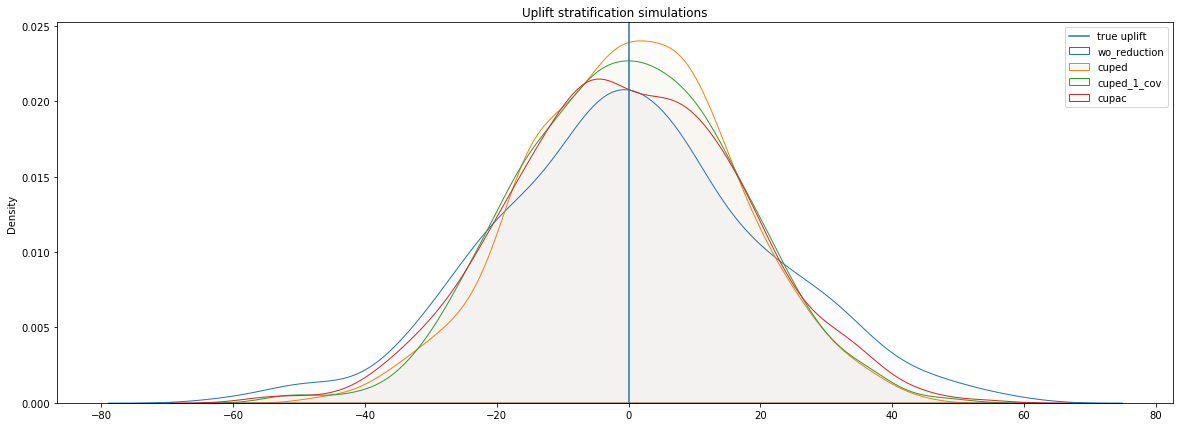

In [503]:
table_results = summary_results(effects_sim, 
                                pvalues_sim, 
                                ci_lens_sim, 
                                methods, 
                                alpha = 0.05)

In [504]:
table_results

,wo_reduction,cuped,cuped_1_cov,cupac,match_on_rf,matched_control,matched_control2
variance_reduction,1.000000,0.593765,0.648209,0.741761,NaN,NaN,NaN
bias,0.000000,-0.096992,0.288327,0.424694,NaN,NaN,NaN
std,20.336408,15.670459,16.373135,17.514842,NaN,NaN,NaN
mean,0.145854,0.242846,-0.142473,-0.278839,NaN,NaN,NaN
lvl_05,0.061000,0.059000,0.051000,0.063000,NaN,NaN,NaN
lvl_01,0.015000,0.011000,0.013000,0.013000,NaN,NaN,NaN
CI_len,77.428560,59.073980,61.842920,65.879671,NaN,NaN,NaN
